In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
import math
from pathlib import Path
from skimage.util import img_as_float
from skimage import data, color, morphology, img_as_float
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.model_selection import train_test_split as tts
import imageio
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn import datasets, svm, pipeline
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
### First create train and test, and put into classes

In [3]:
IMAGE_DIRECTORY_1 = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_images_part_1"
IMAGE_DIRECTORY_2 = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_images_part_2"
trimmed_data = pd.read_csv("trimmed_dataset.csv",index_col=0)
trimmed_data.head()

,lesion_id,image_id,dx
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [4]:
trimmed_data.sort_values(by="lesion_id",axis=0,inplace=True)

trimmed_data.drop("lesion_id",axis=1,inplace=True)
trimmed_data.head()

,image_id,dx
9187,ISIC_0028498,nv
9188,ISIC_0025346,nv
726,ISIC_0027859,bkl
1661,ISIC_0032622,mel
1660,ISIC_0033848,mel


In [5]:
row_keys = trimmed_data.columns.values
trimmed_data.values

array([['ISIC_0028498', 'nv'],
       ['ISIC_0025346', 'nv'],
       ['ISIC_0027859', 'bkl'],
       ...,
       ['ISIC_0026118', 'bcc'],
       ['ISIC_0029820', 'bcc'],
       ['ISIC_0027059', 'nv']], dtype=object)

In [6]:
d = dict(zip(trimmed_data["image_id"],trimmed_data["dx"]))
d

{'ISIC_0028498': 'nv',
 'ISIC_0025346': 'nv',
 'ISIC_0027859': 'bkl',
 'ISIC_0032622': 'mel',
 'ISIC_0033848': 'mel',
 'ISIC_0034246': 'mel',
 'ISIC_0027886': 'nv',
 'ISIC_0024645': 'nv',
 'ISIC_0024579': 'akiec',
 'ISIC_0029638': 'akiec',
 'ISIC_0025577': 'akiec',
 'ISIC_0030591': 'akiec',
 'ISIC_0034162': 'mel',
 'ISIC_0032187': 'mel',
 'ISIC_0032583': 'mel',
 'ISIC_0033879': 'nv',
 'ISIC_0029868': 'nv',
 'ISIC_0029779': 'bcc',
 'ISIC_0029201': 'bcc',
 'ISIC_0026439': 'bcc',
 'ISIC_0027730': 'nv',
 'ISIC_0024678': 'nv',
 'ISIC_0029348': 'nv',
 'ISIC_0030085': 'nv',
 'ISIC_0024655': 'nv',
 'ISIC_0031366': 'nv',
 'ISIC_0025759': 'nv',
 'ISIC_0025640': 'nv',
 'ISIC_0031453': 'nv',
 'ISIC_0029142': 'nv',
 'ISIC_0025894': 'nv',
 'ISIC_0032122': 'nv',
 'ISIC_0025396': 'nv',
 'ISIC_0031922': 'akiec',
 'ISIC_0026773': 'nv',
 'ISIC_0031377': 'mel',
 'ISIC_0026144': 'nv',
 'ISIC_0027141': 'df',
 'ISIC_0028271': 'nv',
 'ISIC_0026126': 'nv',
 'ISIC_0024349': 'nv',
 'ISIC_0029325': 'nv',
 'ISIC_0

### DO NOT RUN BELOW AGAIN

In [7]:
train_dir = "C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/train"
test_dir = "C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/test"


BATCH_SIZE = 32
IMG_SIZE = (450,600)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                       shuffle=True,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE)

Found 7962 files belonging to 7 classes.
Found 2053 files belonging to 7 classes.


In [8]:
class_names = train_dataset.class_names

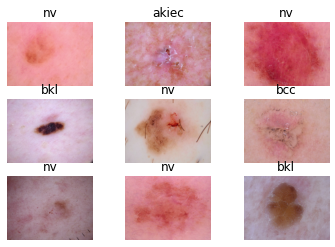

In [9]:
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
val_batches = tf.data.experimental.cardinality(test_dataset)
validation_dataset = test_dataset.take(val_batches // 5)
test_dataset = test_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 13
Number of test batches: 52


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch[0])

tf.Tensor(
[[[0.         0.         0.         ... 0.         0.22530076 0.        ]
  [0.         0.         0.         ... 0.         2.1525283  0.8195865 ]
  [0.         0.         0.         ... 0.         2.5754068  0.5267854 ]
  ...
  [0.         0.         0.         ... 0.         1.9666461  0.01318263]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         3.5982785  0.18126877]
  [0.         0.         0.         ... 0.         3.949216   0.02274218]
  [0.         0.         0.         ... 0.         4.1062217  0.        ]
  ...
  [0.         0.         0.         ... 0.         4.131633   0.        ]
  [0.         0.         0.         ... 0.         1.8970212  0.        ]
  [0.         0.         0.         ... 0.         0.9858169  0.        ]]

 [[0.         0.         0.         ... 0.         2.3028696  0.        ]
  [0.      

In [18]:
print(feature_batch.shape)

(32, 15, 19, 1280)


In [19]:
base_model.trainable = False

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [27]:
prediction_layer = tf.keras.layers.Dense(7)#,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


In [28]:
inputs = tf.keras.Input(shape=(450, 600, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [38]:
base_learning_rate = 0.0001
callbacks = EarlyStopping(monitor="loss",patience=3,restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 450, 600, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 450, 600, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 450, 600, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 450, 600, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 15, 19, 1280)     2257984   
 ional)                                                          
                                                           

In [40]:
len(model.trainable_variables)

2

In [42]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [43]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset)

Epoch 1/30
249/249 [==============================] - 55s 212ms/step - loss: 0.7694 - accuracy: 0.7277 - val_loss: 0.7797 - val_accuracy: 0.7190
Epoch 2/30
249/249 [==============================] - 53s 212ms/step - loss: 0.7542 - accuracy: 0.7290 - val_loss: 0.7755 - val_accuracy: 0.7208
Epoch 3/30
249/249 [==============================] - 45s 181ms/step - loss: 0.7461 - accuracy: 0.7336 - val_loss: 0.7710 - val_accuracy: 0.7208
Epoch 4/30
249/249 [==============================] - 45s 179ms/step - loss: 0.7383 - accuracy: 0.7327 - val_loss: 0.7546 - val_accuracy: 0.7269
Epoch 5/30
249/249 [==============================] - 45s 178ms/step - loss: 0.7256 - accuracy: 0.7361 - val_loss: 0.7470 - val_accuracy: 0.7337
Epoch 6/30
249/249 [==============================] - 44s 178ms/step - loss: 0.7274 - accuracy: 0.7364 - val_loss: 0.7452 - val_accuracy: 0.7312
Epoch 7/30
249/249 [==============================] - 44s 178ms/step - loss: 0.7238 - accuracy: 0.7394 - val_loss: 0.7425 - val_ac

In [44]:
loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 3s 181ms/step - loss: 0.6436 - accuracy: 0.7548


In [45]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.64
initial accuracy: 0.75
